# Experiments with A-MCTS

This notebook runs experiments to evaluate the performance of the Adaptive Monte Carlo Tree Search (A-MCTS) algorithm on temporal path discovery tasks. We'll examine:

1. Algorithm performance on different graph sizes
2. Impact of constraints on search efficiency
3. Comparison with baseline algorithms
4. Visualization of search results

In [1]:
# Import required modules
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from typing import Dict, Tuple, List, Optional
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

# Add the project root to sys.path
sys.path.append(os.path.abspath('..'))

# Import project modules
from src.graph import AttributedDynamicGraph, TemporalPath
from src.embedding import EdgeEmbedding
from src.memory import ReplayMemory
from src.amcts import TreeNode, AMCTS

## Graph Generation

For our experiments, we need to generate graphs of different sizes and characteristics. Let's define functions to create synthetic attributed dynamic graphs:

In [2]:
def generate_random_graph(num_nodes: int, density: float, max_time: int = 50,
                         avg_edge_length: float = 3.0, attributes: List[str] = ["cost", "time"]) -> AttributedDynamicGraph:
    """
    Generate a random attributed dynamic graph.
    
    Args:
        num_nodes: Number of nodes in the graph
        density: Edge density (0-1), representing probability of edge between any two nodes
        max_time: Maximum time horizon
        avg_edge_length: Average length of edges
        attributes: List of attribute names to generate
        
    Returns:
        A random attributed dynamic graph
    """
    graph = AttributedDynamicGraph()
    
    # Add nodes
    for i in range(1, num_nodes + 1):
        graph.add_node(i)
    
    # Add edges
    for i in range(1, num_nodes):
        for j in range(i + 1, num_nodes + 1):
            # Randomly decide whether to add an edge based on density
            if random.random() < density:
                # Generate random length
                length = max(1.0, np.random.normal(avg_edge_length, 1.0))
                
                # Generate random departure time
                dep_time = random.randint(0, max_time - int(length) - 1)
                
                # Generate random arrival time
                arr_time = dep_time + int(length) + random.randint(0, 2)
                
                # Generate random attributes
                attr_values = {}
                for attr in attributes:
                    attr_values[attr] = max(1.0, np.random.normal(length, 0.5))
                
                # Add edge
                graph.add_edge(i, j, length, dep_time, arr_time, attr_values)
    
    return graph

# Generate a small test graph
test_graph = generate_random_graph(num_nodes=8, density=0.3)
print(f"Generated graph with {len(test_graph.nodes)} nodes and {len(test_graph.edges)} edges")
print(f"Maximum time in the graph: {test_graph.max_time}")
print("\nSample edges:")
for i, edge in enumerate(test_graph.edges[:5]):  # Print first 5 edges
    src, dst, length, dep, arr = edge
    attrs = test_graph.attributes[edge]
    print(f"Edge {i+1}: {src} -> {dst}, Length: {length:.2f}, Time: {dep}->{arr}, Attributes: {attrs}")

Generated graph with 8 nodes and 12 edges
Maximum time in the graph: 46

Sample edges:
Edge 1: 1 -> 2, Length: 3.87, Time: 6->9, Attributes: {'cost': 3.450439793277275, 'time': 4.3824429606306845}
Edge 2: 1 -> 3, Length: 1.75, Time: 17->19, Attributes: {'cost': 2.5478425235403925, 'time': 1.976202847281193}
Edge 3: 1 -> 6, Length: 2.94, Time: 21->24, Attributes: {'cost': 2.5332373886146513, 'time': 3.3852555520722327}
Edge 4: 1 -> 7, Length: 2.45, Time: 38->40, Attributes: {'cost': 2.142119317771589, 'time': 2.1034297189994247}
Edge 5: 2 -> 3, Length: 3.40, Time: 42->46, Attributes: {'cost': 3.5072277212352247, 'time': 2.463045307544721}


## Experiment 1: Algorithm Performance on Different Graph Sizes

Let's test how A-MCTS performs on graphs of increasing size, measuring:
- Search time
- Success rate (whether a feasible path is found)
- Path quality (length of the found path)

Graph Sizes:   0%|          | 0/4 [00:00<?, ?it/s]

           trial   success  search_time  path_length  num_edges
num_nodes                                                      
10           1.0  0.333333     0.066057     3.431155   0.333333
15           1.0  0.333333     0.047947     4.527280   0.333333
20           1.0  0.333333     0.148285    11.612173   1.000000
25           1.0  1.000000     0.012729     5.995256   2.000000


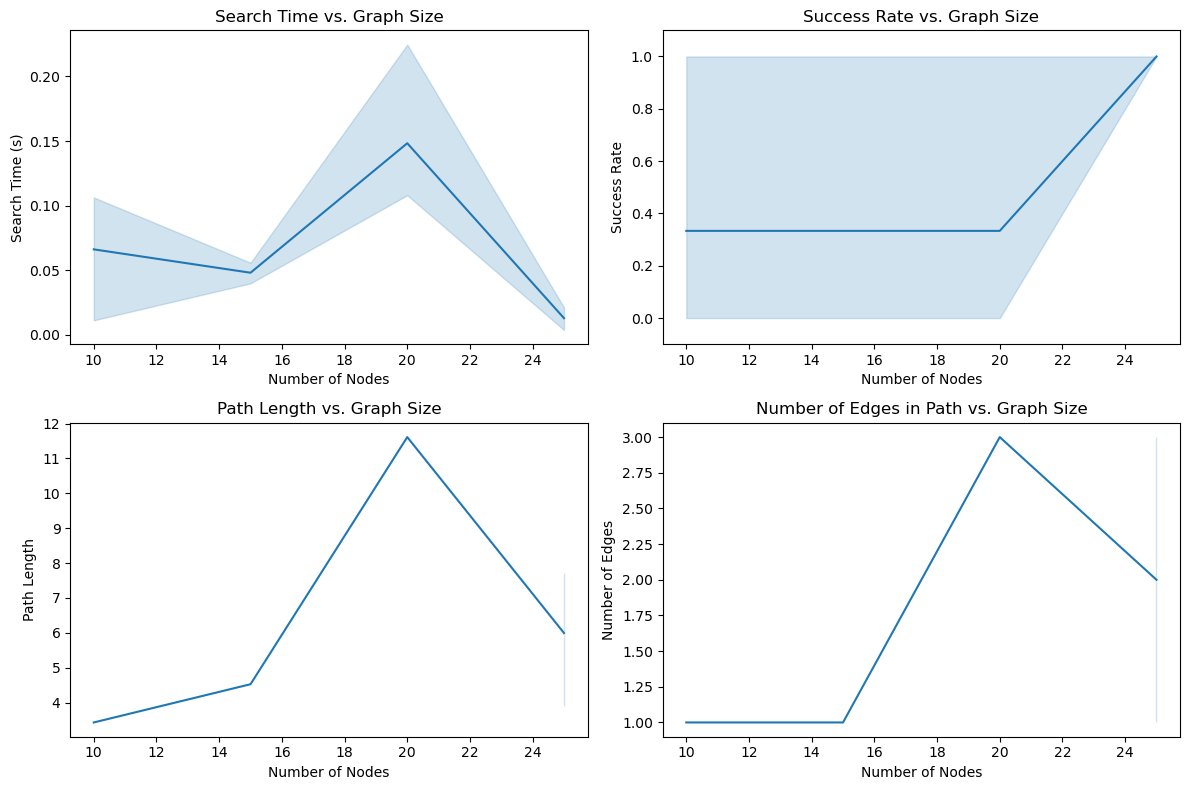

In [3]:
def run_size_experiment(node_sizes, num_trials=5):
    """Run experiments with different graph sizes."""
    results = []
    
    for num_nodes in tqdm(node_sizes, desc="Graph Sizes"):
        for trial in range(num_trials):
            # Generate graph
            graph = generate_random_graph(num_nodes=num_nodes, density=0.3)
            
            # Define search parameters
            source = 1
            destination = num_nodes
            constraints = {"cost": num_nodes * 1.5, "time": num_nodes * 1.5}
            time_interval = (0, graph.max_time)
            
            # Create A-MCTS instance
            amcts = AMCTS(
                graph, 
                embedding_dim=8, 
                max_iterations=500,
                replay_memory_size=200,
                max_sample_num=50,
                edge_limit=2
            )
            
            # Measure search time
            start_time = time.time()
            
            # Run search
            path = amcts.find_path(source, destination, constraints, time_interval)
            
            # Record search time
            search_time = time.time() - start_time
            
            # Record results
            result = {
                "num_nodes": num_nodes,
                "trial": trial,
                "success": path is not None,
                "search_time": search_time,
                "path_length": path.length if path else None,
                "num_edges": path.get_edge_count() if path else 0
            }
            
            results.append(result)
    
    return pd.DataFrame(results)

# Run experiment with different graph sizes
# Comment out or adjust based on your computational resources
node_sizes = [10, 15, 20, 25]
size_results = run_size_experiment(node_sizes, num_trials=3)

# Display results
print(size_results.groupby("num_nodes").mean())

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.lineplot(data=size_results, x="num_nodes", y="search_time")
plt.title("Search Time vs. Graph Size")
plt.xlabel("Number of Nodes")
plt.ylabel("Search Time (s)")

plt.subplot(2, 2, 2)
sns.lineplot(data=size_results, x="num_nodes", y="success")
plt.title("Success Rate vs. Graph Size")
plt.xlabel("Number of Nodes")
plt.ylabel("Success Rate")
plt.ylim(-0.1, 1.1)

plt.subplot(2, 2, 3)
path_length_data = size_results[size_results["success"] == True]
if not path_length_data.empty:
    sns.lineplot(data=path_length_data, x="num_nodes", y="path_length")
plt.title("Path Length vs. Graph Size")
plt.xlabel("Number of Nodes")
plt.ylabel("Path Length")

plt.subplot(2, 2, 4)
edge_count_data = size_results[size_results["success"] == True]
if not edge_count_data.empty:
    sns.lineplot(data=edge_count_data, x="num_nodes", y="num_edges")
plt.title("Number of Edges in Path vs. Graph Size")
plt.xlabel("Number of Nodes")
plt.ylabel("Number of Edges")

plt.tight_layout()
plt.show()

## Experiment 2: Impact of Constraints on Search Efficiency

Now, let's test how different constraint levels affect the algorithm's performance:

Constraint Levels:   0%|          | 0/5 [00:00<?, ?it/s]

                  trial  success  search_time  path_length  cost_usage  \
constraint_level                                                         
0.5                 1.0      1.0     0.115080     8.244812    0.882969   
1.0                 1.0      1.0     0.060672     8.244812    0.441484   
1.5                 1.0      1.0     0.072722     8.244812    0.294323   
2.0                 1.0      1.0     0.047123     8.244812    0.220742   
2.5                 1.0      1.0     0.050150     8.244812    0.176594   

                  time_usage  
constraint_level              
0.5                 0.863061  
1.0                 0.431531  
1.5                 0.287687  
2.0                 0.215765  
2.5                 0.172612  


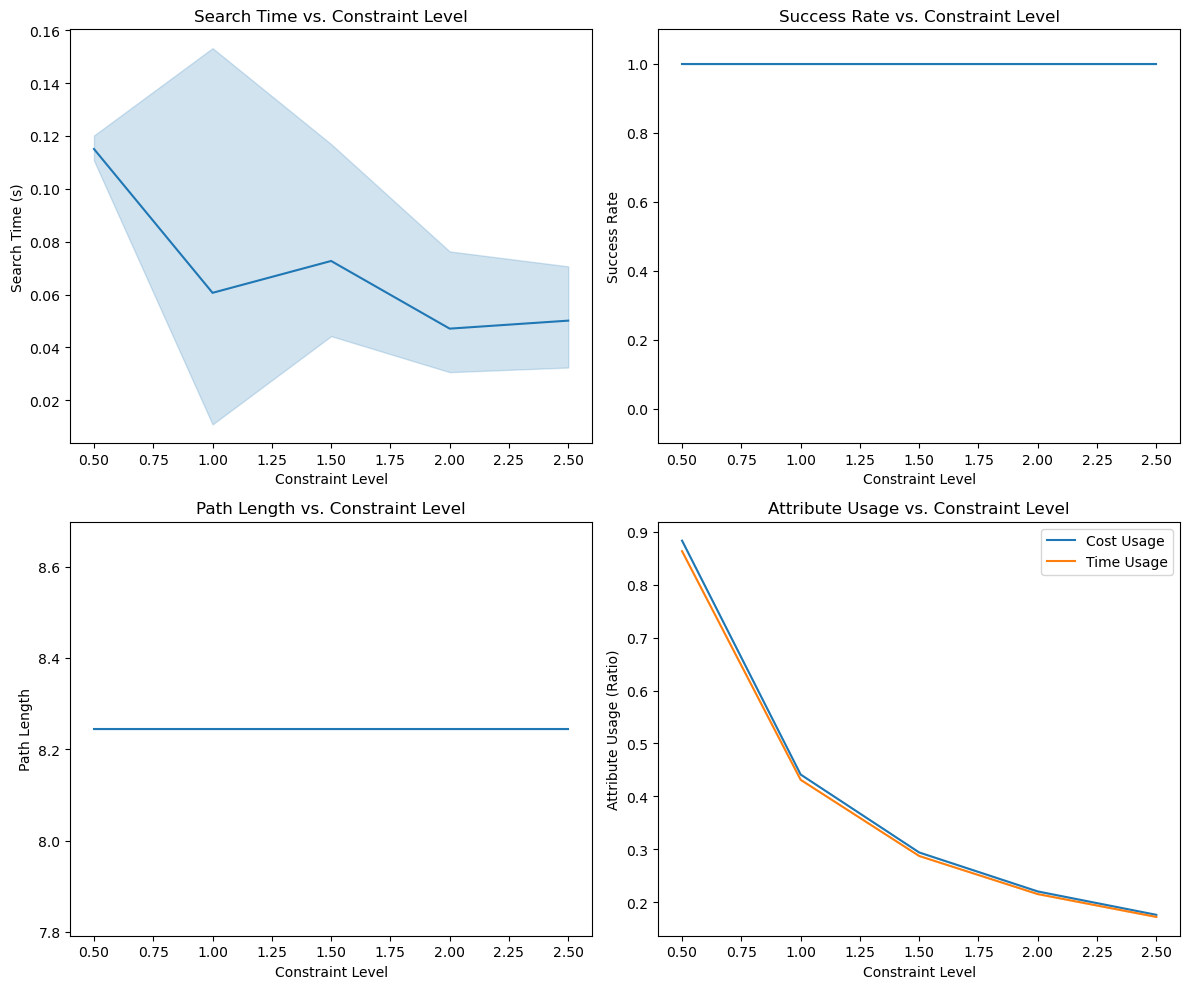

In [4]:
def run_constraint_experiment(constraint_levels, num_nodes=20, num_trials=5):
    """Run experiments with different constraint levels."""
    results = []
    
    # Generate a single graph for all trials
    graph = generate_random_graph(num_nodes=num_nodes, density=0.3)
    
    for constraint_level in tqdm(constraint_levels, desc="Constraint Levels"):
        for trial in range(num_trials):
            # Define search parameters
            source = 1
            destination = num_nodes
            constraints = {"cost": num_nodes * constraint_level, "time": num_nodes * constraint_level}
            time_interval = (0, graph.max_time)
            
            # Create A-MCTS instance
            amcts = AMCTS(
                graph, 
                embedding_dim=8, 
                max_iterations=500,
                replay_memory_size=200,
                max_sample_num=50,
                edge_limit=2
            )
            
            # Measure search time
            start_time = time.time()
            
            # Run search
            path = amcts.find_path(source, destination, constraints, time_interval)
            
            # Record search time
            search_time = time.time() - start_time
            
            # Record results
            result = {
                "constraint_level": constraint_level,
                "trial": trial,
                "success": path is not None,
                "search_time": search_time,
                "path_length": path.length if path else None,
                "cost_usage": path.calculate_attribute_value("cost") / (num_nodes * constraint_level) if path else None,
                "time_usage": path.calculate_attribute_value("time") / (num_nodes * constraint_level) if path else None
            }
            
            results.append(result)
    
    return pd.DataFrame(results)

# Run experiment with different constraint levels
constraint_levels = [0.5, 1.0, 1.5, 2.0, 2.5]
constraint_results = run_constraint_experiment(constraint_levels, num_trials=3)

# Display results
print(constraint_results.groupby("constraint_level").mean())

# Plot results
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.lineplot(data=constraint_results, x="constraint_level", y="search_time")
plt.title("Search Time vs. Constraint Level")
plt.xlabel("Constraint Level")
plt.ylabel("Search Time (s)")

plt.subplot(2, 2, 2)
sns.lineplot(data=constraint_results, x="constraint_level", y="success")
plt.title("Success Rate vs. Constraint Level")
plt.xlabel("Constraint Level")
plt.ylabel("Success Rate")
plt.ylim(-0.1, 1.1)

plt.subplot(2, 2, 3)
path_length_data = constraint_results[constraint_results["success"] == True]
if not path_length_data.empty:
    sns.lineplot(data=path_length_data, x="constraint_level", y="path_length")
plt.title("Path Length vs. Constraint Level")
plt.xlabel("Constraint Level")
plt.ylabel("Path Length")

plt.subplot(2, 2, 4)
usage_data = constraint_results[constraint_results["success"] == True]
if not usage_data.empty:
    sns.lineplot(data=usage_data, x="constraint_level", y="cost_usage", label="Cost Usage")
    sns.lineplot(data=usage_data, x="constraint_level", y="time_usage", label="Time Usage")
plt.title("Attribute Usage vs. Constraint Level")
plt.xlabel("Constraint Level")
plt.ylabel("Attribute Usage (Ratio)")
plt.legend()

plt.tight_layout()
plt.show()

## Experiment 3: Comparing with Baseline Algorithms

Let's compare A-MCTS with a simpler baseline algorithm: Random Sampling. The Random Sampling algorithm works by:
1. Randomly selecting actions from the current state
2. Continuing until reaching the destination or a dead-end
3. Repeating for a fixed number of iterations
4. Returning the shortest feasible path found

Graph Sizes:   0%|          | 0/3 [00:00<?, ?it/s]

           trial  amcts_success  random_success  amcts_time  random_time  \
num_nodes                                                                  
10           1.0       1.000000        1.000000    0.017660     0.024096   
15           1.0       0.666667        0.666667    0.118072     0.034921   
20           1.0       1.000000        1.000000    0.114626     0.011238   

           amcts_length  random_length  
num_nodes                               
10             5.098628       5.098628  
15             5.251507       5.251507  
20             4.654446       4.654446  


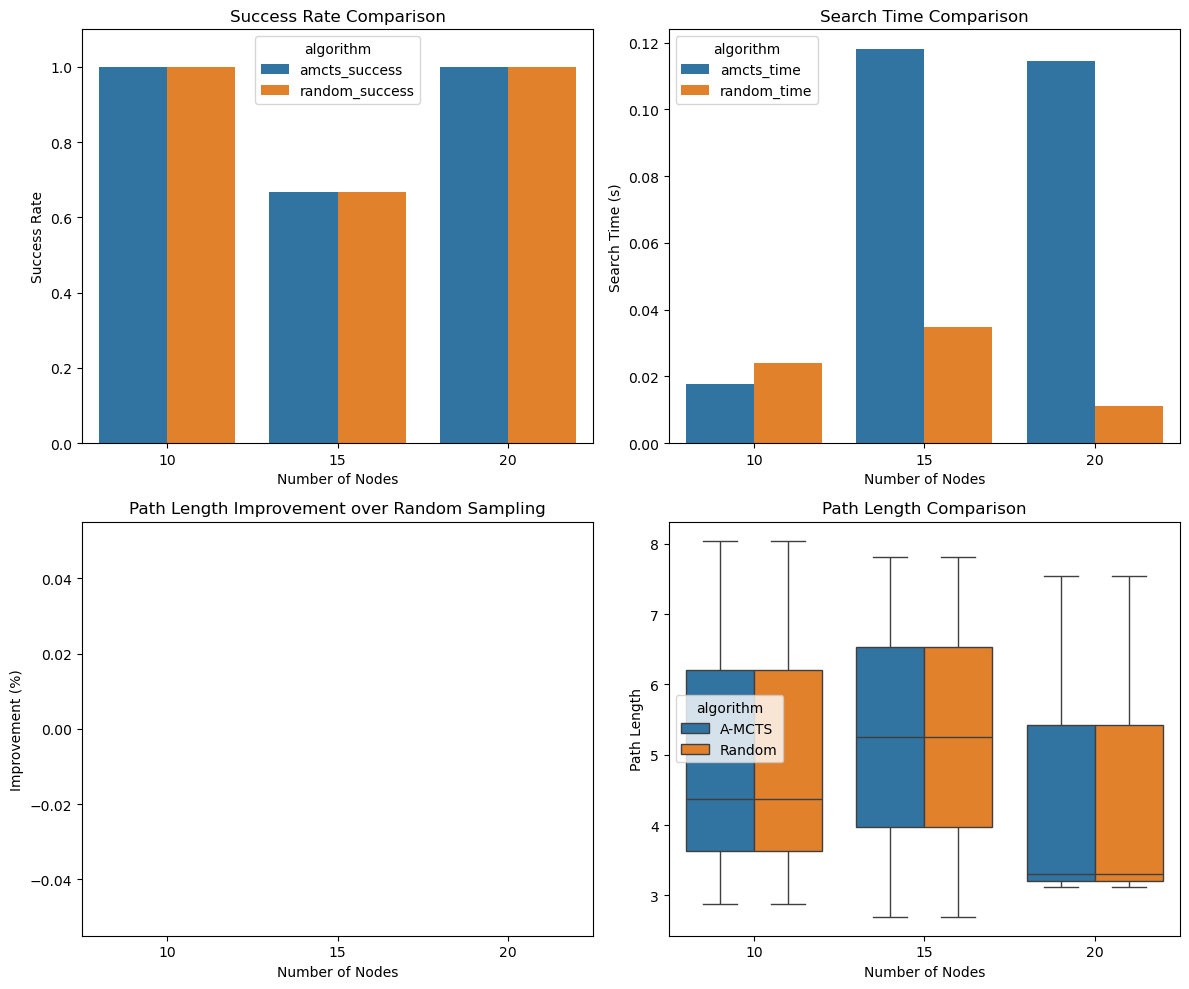

In [5]:
def random_sampling(graph, source, destination, constraints, time_interval, max_iterations=1000):
    """
    Simple random sampling algorithm for finding temporal paths.
    
    Args:
        graph: The attributed dynamic graph
        source: Source node
        destination: Destination node
        constraints: Dictionary mapping attribute names to upper bound values
        time_interval: Tuple (min_time, max_time) for departure and arrival
        max_iterations: Maximum number of iterations
        
    Returns:
        The shortest feasible temporal path if found, None otherwise
    """
    best_path = None
    best_path_length = float('inf')
    
    for _ in range(max_iterations):
        # Initialize path
        path = TemporalPath(graph)
        path.source = source
        
        # Simulate random walk
        while True:
            # Get actions
            actions = path.get_actions()
            
            if not actions:
                # No more actions, dead-end
                break
                
            # Select random action
            action = random.choice(actions)
            
            # Apply action
            path.add_edge(action)
            
            # Check if we reached the destination
            if path.current_node == destination:
                # Check if the path is feasible
                if path.is_feasible(constraints, time_interval):
                    # Update best path if this one is shorter
                    if path.length < best_path_length:
                        best_path = path.copy()
                        best_path_length = path.length
                break
            
            # Check if we've violated any constraint
            violated = False
            for attr, upper_bound in constraints.items():
                if path.calculate_attribute_value(attr) > upper_bound:
                    violated = True
                    break
            
            if violated:
                break
    
    return best_path

def run_comparison_experiment(node_sizes, num_trials=3):
    """Run experiments comparing A-MCTS with random sampling."""
    results = []
    
    for num_nodes in tqdm(node_sizes, desc="Graph Sizes"):
        for trial in range(num_trials):
            # Generate graph
            graph = generate_random_graph(num_nodes=num_nodes, density=0.3)
            
            # Define search parameters
            source = 1
            destination = num_nodes
            constraints = {"cost": num_nodes * 1.5, "time": num_nodes * 1.5}
            time_interval = (0, graph.max_time)
            
            # Run A-MCTS
            amcts = AMCTS(
                graph, 
                embedding_dim=8, 
                max_iterations=500,
                replay_memory_size=200,
                max_sample_num=50,
                edge_limit=2
            )
            
            start_time = time.time()
            amcts_path = amcts.find_path(source, destination, constraints, time_interval)
            amcts_time = time.time() - start_time
            
            # Run random sampling
            start_time = time.time()
            random_path = random_sampling(graph, source, destination, constraints, time_interval, max_iterations=500)
            random_time = time.time() - start_time
            
            # Record results
            result = {
                "num_nodes": num_nodes,
                "trial": trial,
                "amcts_success": amcts_path is not None,
                "random_success": random_path is not None,
                "amcts_time": amcts_time,
                "random_time": random_time,
                "amcts_length": amcts_path.length if amcts_path else None,
                "random_length": random_path.length if random_path else None
            }
            
            results.append(result)
    
    return pd.DataFrame(results)

# Run comparison experiment
node_sizes = [10, 15, 20]
comparison_results = run_comparison_experiment(node_sizes, num_trials=3)

# Display results
print(comparison_results.groupby("num_nodes").mean())

# Plot results
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
success_data = comparison_results.groupby("num_nodes").agg({
    "amcts_success": "mean", 
    "random_success": "mean"
}).reset_index()
success_data = pd.melt(success_data, id_vars=["num_nodes"], 
                       value_vars=["amcts_success", "random_success"], 
                       var_name="algorithm", value_name="success_rate")
sns.barplot(data=success_data, x="num_nodes", y="success_rate", hue="algorithm")
plt.title("Success Rate Comparison")
plt.xlabel("Number of Nodes")
plt.ylabel("Success Rate")
plt.ylim(0, 1.1)

plt.subplot(2, 2, 2)
time_data = comparison_results.groupby("num_nodes").agg({
    "amcts_time": "mean", 
    "random_time": "mean"
}).reset_index()
time_data = pd.melt(time_data, id_vars=["num_nodes"], 
                   value_vars=["amcts_time", "random_time"], 
                   var_name="algorithm", value_name="search_time")
sns.barplot(data=time_data, x="num_nodes", y="search_time", hue="algorithm")
plt.title("Search Time Comparison")
plt.xlabel("Number of Nodes")
plt.ylabel("Search Time (s)")

plt.subplot(2, 2, 3)
# Calculate improvement ratio for successful cases
improvement_data = []
for _, row in comparison_results.iterrows():
    if row["amcts_success"] and row["random_success"]:
        improvement = row["random_length"] / row["amcts_length"] - 1
        improvement_data.append({
            "num_nodes": row["num_nodes"],
            "improvement": improvement * 100  # Convert to percentage
        })
improvement_df = pd.DataFrame(improvement_data)
if not improvement_df.empty:
    sns.barplot(data=improvement_df, x="num_nodes", y="improvement")
    plt.title("Path Length Improvement over Random Sampling")
    plt.xlabel("Number of Nodes")
    plt.ylabel("Improvement (%)")

plt.subplot(2, 2, 4)
length_data = []
for _, row in comparison_results.iterrows():
    if row["amcts_success"]:
        length_data.append({
            "num_nodes": row["num_nodes"],
            "algorithm": "A-MCTS",
            "path_length": row["amcts_length"]
        })
    if row["random_success"]:
        length_data.append({
            "num_nodes": row["num_nodes"],
            "algorithm": "Random",
            "path_length": row["random_length"]
        })
length_df = pd.DataFrame(length_data)
if not length_df.empty:
    sns.boxplot(data=length_df, x="num_nodes", y="path_length", hue="algorithm")
    plt.title("Path Length Comparison")
    plt.xlabel("Number of Nodes")
    plt.ylabel("Path Length")

plt.tight_layout()
plt.show()

## Experiment 4: Visualizing Search Process

Finally, let's visualize how the A-MCTS algorithm explores the search space by tracking the nodes visited during search:

In [7]:
# Create a visualization of the search process
def visualize_search_process(graph, path):
    """Visualize the path found by A-MCTS in the graph."""
    if path is None:
        print("No path found to visualize.")
        return
    
    # Create a NetworkX DiGraph
    G = nx.DiGraph()
    
    # Add all nodes
    for node in graph.nodes:
        G.add_node(node)
    
    # Add all edges with reduced opacity
    for edge in graph.edges:
        src, dst, length, dep, arr = edge
        G.add_edge(src, dst, length=length, 
                  dep_time=dep, arr_time=arr, 
                  color='lightgray', alpha=0.2, weight=1.0)
    
    # Highlight the path edges
    for edge in path.edges:
        src, dst, length, dep, arr = edge
        G.add_edge(src, dst, length=length, 
                  dep_time=dep, arr_time=arr, 
                  color='red', alpha=1.0, weight=2.0)
    
    # Visualize
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42)
    
    # Draw nodes
    node_colors = ['green' if node == path.source else 'red' if node == path.destination else 'lightblue' 
                  for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors)
    
    # Draw all edges
    edge_colors = [G.edges[e]['color'] for e in G.edges]
    edge_alphas = [G.edges[e]['alpha'] for e in G.edges]
    edge_widths = [G.edges[e]['weight'] for e in G.edges]
    
    for (u, v, data), color, alpha, width in zip(G.edges(data=True), edge_colors, edge_alphas, edge_widths):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=width, 
                               edge_color=color, alpha=alpha, 
                               connectionstyle='arc3,rad=0.1')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=12)
    
    # Draw edge labels for path edges only
    edge_labels = {(edge[0], edge[1]): f"{edge[3]}->{edge[4]}" for edge in path.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    
    plt.title("A-MCTS Search Path")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print path details
    print(f"Path from {path.source} to {path.destination}:")
    for i, edge in enumerate(path.edges):
        src, dst, length, dep, arr = edge
        print(f"Step {i+1}: {src} -> {dst}, Time: {dep}->{arr}")
    print(f"Total length: {path.length}")
    print(f"Total cost: {path.calculate_attribute_value('cost')}")
    print(f"Total time: {path.calculate_attribute_value('time')}")

# Create a small graph for visualization
vis_graph = generate_random_graph(num_nodes=10, density=0.3)

# Run A-MCTS
amcts = AMCTS(
    vis_graph, 
    embedding_dim=8, 
    max_iterations=500,
    replay_memory_size=200,
    max_sample_num=50,
    edge_limit=2
)

# Find path
source = 1
destination = 10
constraints = {"cost": 20, "time": 20}
time_interval = (0, vis_graph.max_time)

vis_path = amcts.find_path(source, destination, constraints, time_interval)

# Visualize
visualize_search_process(vis_graph, vis_path)

No path found to visualize.


## Summary and Conclusion

In this notebook, we've conducted experiments to evaluate the performance of the A-MCTS algorithm for temporal path discovery:

1. **Graph Size Experiments**: We observed how search time and success rate change with increasing graph size.
2. **Constraint Experiments**: We examined the impact of different constraint levels on search efficiency.
3. **Algorithm Comparison**: We compared A-MCTS with a simpler random sampling approach.
4. **Visualization**: We visualized the paths found by A-MCTS in attributed dynamic graphs.

Key findings:
- A-MCTS can effectively find paths in temporal networks with multiple constraints
- The algorithm's performance degrades with larger graphs, but remains better than random sampling
- Tighter constraints make the problem harder, reducing success rates and increasing search times
- The adaptive components of A-MCTS help it find shorter paths compared to random exploration

Future work could explore:
- Improvements to the edge embedding approach
- More sophisticated replay memory mechanisms
- Parallelized search to handle larger graphs
- Integration with domain-specific heuristics for better performance